### Content

### 1.  Mounting the google drive to google colab

In [1]:
# mounting the my googledrive to google.colab
# this is needed to save my weights, Neural Network model while it is running
# the model, weights can be accessed at a later time if google colab disconnects

from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


### 2. Standard Imports for Recurrent Neural Networks

In [2]:
from __future__ import print_function

# For preprocessing the text into integer(ids)
# For plotting the accuracy and loss curve
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# regular expression to proprocess raw_text
import regex as re

# To instantiate Recurrent Neural Networks
from keras.models import Sequential
# My model will be dense with all the nodes to 'touch'
from keras.layers import Dense, Activation
# LSTM, GRU
from keras.layers import LSTM, GRU
#from keras.optimizers import RMSprop, adam

# to create a callback, this will be a checkpoint
from keras.callbacks import LambdaCallback

# need to create a random seed to create a text, so the model will learn the sequence
import random
import sys
import io

### 3. Loading the txt file that is used fro RNN

In [5]:
# cd to pull my txt file from my google drive into google colab
#%cd /content/gdrive/My Drive/Capstone/Data/

# filename called 'out.txt'
filename = "rnn_text.txt"

# extract the raw text
raw_text = open(filename, 'r', encoding='utf-8').read()


# lowercase my text
data = raw_text.lower()
# remove url links
data = re.sub(r'\w+:\/{2}[\d\w-]+(\.[\d\w-]+)*(?:(?:\/[^\s/]*))*', '',data)
# keep punctuations this time
data = re.sub("[^a-zA-Z.,?!'\";:-]", " ", data)
# strip to remove empty spaces before beginning and end of string
data = data.strip()

### 4. Exploring text dataset

In [6]:
# set - find a list of specific characters 
# list - to convert characters into a list
# sorted - to sort list into alphabetical order
chars = sorted(list(set(data)))

# count of total characters
print('total chars: ', len(chars))

total chars:  36


In [7]:
# mapping the characters to numerical values & vice versa
# this will be crucial for feeding into our RNN model
# and required to map the predicted numerical values back to their corresponding characters

char_indices = dict((c, i) for i, c in enumerate(chars))

# noted that in this list of character mapping, there is no 'z' in text
# noted that ' ' white space is counted as a character
char_indices

{' ': 0,
 '!': 1,
 '"': 2,
 "'": 3,
 ',': 4,
 '-': 5,
 '.': 6,
 ':': 7,
 ';': 8,
 '?': 9,
 'a': 10,
 'b': 11,
 'c': 12,
 'd': 13,
 'e': 14,
 'f': 15,
 'g': 16,
 'h': 17,
 'i': 18,
 'j': 19,
 'k': 20,
 'l': 21,
 'm': 22,
 'n': 23,
 'o': 24,
 'p': 25,
 'q': 26,
 'r': 27,
 's': 28,
 't': 29,
 'u': 30,
 'v': 31,
 'w': 32,
 'x': 33,
 'y': 34,
 'z': 35}

In [8]:
# this will be used from mapping numerical values back to characters
indices_char = dict((i, c) for i, c in enumerate(chars))

indices_char

{0: ' ',
 1: '!',
 2: '"',
 3: "'",
 4: ',',
 5: '-',
 6: '.',
 7: ':',
 8: ';',
 9: '?',
 10: 'a',
 11: 'b',
 12: 'c',
 13: 'd',
 14: 'e',
 15: 'f',
 16: 'g',
 17: 'h',
 18: 'i',
 19: 'j',
 20: 'k',
 21: 'l',
 22: 'm',
 23: 'n',
 24: 'o',
 25: 'p',
 26: 'q',
 27: 'r',
 28: 's',
 29: 't',
 30: 'u',
 31: 'v',
 32: 'w',
 33: 'x',
 34: 'y',
 35: 'z'}

### 5. Numerical encode the sentences and features

In [9]:
len(data)

1208987

In [10]:
text = data

In [11]:
maxlen = 100
step = 3
sentences = []
next_chars = []
for i in range(0, len(text) - maxlen, step):
    sentences.append(text[i: i + maxlen])
    next_chars.append(text[i + maxlen])
print('nb sequences:', len(sentences))

nb sequences: 402963


In [12]:
print(sentences[:5])
print(next_chars[:5])

['just auditing this course helped me a lot in learning this language programming. attentive save the ', 't auditing this course helped me a lot in learning this language programming. attentive save the mon', 'uditing this course helped me a lot in learning this language programming. attentive save the money ', 'ting this course helped me a lot in learning this language programming. attentive save the money i w', 'g this course helped me a lot in learning this language programming. attentive save the money i will']
['m', 'e', 'i', 'i', ' ']


In [13]:
len(text)

1208987

In [14]:
X = np.zeros((len(sentences), maxlen, len(chars)), dtype=np.bool)
y = np.zeros((len(sentences), len(chars)), dtype=np.bool)
for i, sentence in enumerate(sentences):
    for t, char in enumerate(sentence):
        X[i, t, char_indices[char]] = 1
    y[i, char_indices[next_chars[i]]] = 1

In [15]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y,  random_state=42, shuffle=False)

### 6. define the model topolgy
 https://towardsdatascience.com/checkpointing-deep-learning-models-in-keras-a652570b8de6

In [16]:
# Define the model architecture 

def create_model():
    #instantial
    model = Sequential()
    model.add(GRU(128, input_shape=(maxlen, len(chars))))
    model.add(Dense(len(chars)))
    model.add(Activation('softmax'))
    
    # Compiling the model
    # as my model are one-hot encoded, i will use categorical_crossentropy
    model.compile(loss='categorical_crossentropy',
             optimizer='adam',
             metrics=['accuracy'])
    
    return model

#create the model
model_ckpt= create_model()

In [17]:
model_ckpt.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 128)               63744     
_________________________________________________________________
dense (Dense)                (None, 36)                4644      
_________________________________________________________________
activation (Activation)      (None, 36)                0         
Total params: 68,388
Trainable params: 68,388
Non-trainable params: 0
_________________________________________________________________


### 7. Creating my ModelCheckpoint and callback requirements

In [18]:
from keras.callbacks import ModelCheckpoint

# specifying where my checkpoint files will be stored
filepath = "/content/gdrive/My Drive/Capstone/Data/"

# this ModelCheckpoint save weights and save the best model as it runs
checkpoint = ModelCheckpoint(filepath, monitor='loss',
                             save_weights_only=True, save_best_only=True,
                             mode='min',verbose=1 )

In [19]:
from keras.callbacks import ReduceLROnPlateau
reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.2,
                              patience=1, min_lr=0.001)

In [20]:
def sample(preds, temperature=1.0):
    # helper function to sample an index from a probability array
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)

In [21]:
def on_epoch_end(epoch, logs):
    # Function invoked at end of each epoch. Prints generated text.
    print()
    print('----- Generating text after Epoch: %d' % epoch)

    start_index = random.randint(0, len(text) - maxlen - 1)
    for diversity in [0.2, 0.5, 1.0, 1.2]:
        print('----- diversity:', diversity)

        generated = ''
        sentence = text[start_index: start_index + maxlen]
        generated += sentence
        print('----- Generating with seed: "' + sentence + '"')
        sys.stdout.write(generated)

        for i in range(400):
            x_pred = np.zeros((1, maxlen, len(chars)))
            for t, char in enumerate(sentence):
                x_pred[0, t, char_indices[char]] = 1.

            preds = model_ckpt.predict(x_pred, verbose=0)[0]
            next_index = sample(preds, diversity)
            next_char = indices_char[next_index]

            generated += next_char
            sentence = sentence[1:] + next_char

            sys.stdout.write(next_char)
            sys.stdout.flush()
        print()
print_callback = LambdaCallback(on_epoch_end=on_epoch_end)

In [22]:
### combining all of my callbacks

callbacks = [print_callback, checkpoint, reduce_lr]

### 8.Training my RNN model

In [23]:
history = model_ckpt.fit(X_train, y_train, batch_size=128, epochs=100, validation_data =(X_test, y_test),callbacks=callbacks)

Epoch 1/100
2362/2362 [==============================] - 54s 9ms/step - loss: 2.3194 - accuracy: 0.3469 - val_loss: 1.4801 - val_accuracy: 0.5797

----- Generating text after Epoch: 0
----- diversity: 0.2
----- Generating with seed: "e course is too easy to learn a lot of useful things. after all, thanks for the great effort!!!!!!!!"
e course is too easy to learn a lot of useful things. after all, thanks for the great effort!!!!!!!!" "i and the course is a course is a course the course and the course is a good the course is a way the course is a great in the course in the course is a learn the course and the course is a lot of the course in python in the course is a learn to the course and the course in the course is and the course and the course in the course is a long and the course is a course and the course in the course
----- diversity: 0.5
----- Generating with seed: "e course is too easy to learn a lot of useful things. after all, thanks for the great effort!!!!!!!!"
e course is

In [ ]:
# when epoch increases 

### 9. evaluating performance of model

In [24]:
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])


In [25]:
train_Loss, train_Accuracy = model_ckpt.evaluate(X_train, y_train, verbose=2)

9445/9445 - 25s - loss: 0.8260 - accuracy: 0.7478


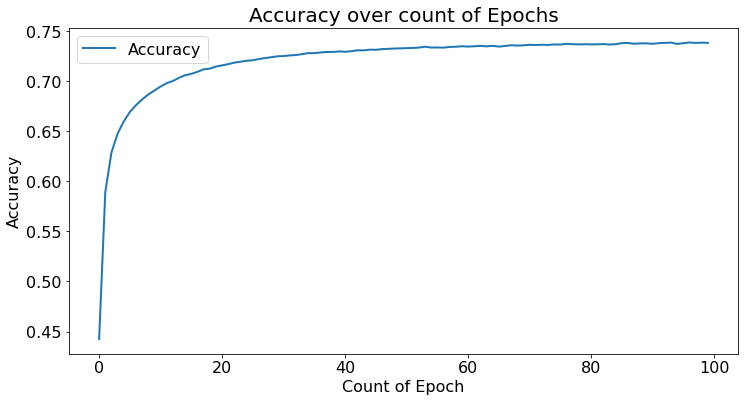

In [26]:
plt.figure(figsize=(12,6))
plt.rcParams['font.size'] = '16'
plt.plot(history.history['accuracy'], label='Accuracy', lw=2)
plt.xlabel('Count of Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy over count of Epochs', fontsize=20)
plt.legend();

No handles with labels found to put in legend.


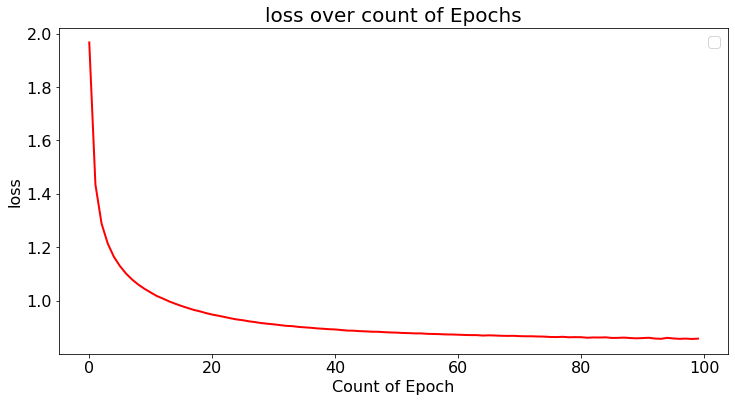

In [27]:
plt.figure(figsize=(12,6))
plt.plot(history.history['loss'], lw=2, color='red')
plt.xlabel('Count of Epoch')
plt.ylabel('loss')
plt.title('loss over count of Epochs', fontsize=20)
plt.legend();

In [28]:
test_Loss, test_Accuracy = model_ckpt.evaluate(X_test, y_test, verbose=2)

3149/3149 - 9s - loss: 1.0881 - accuracy: 0.6939


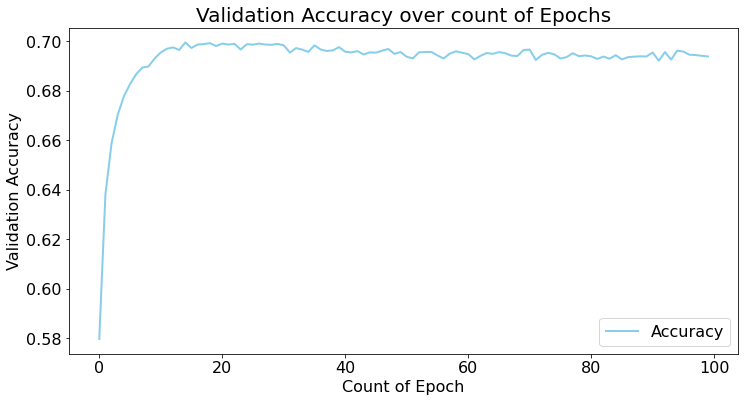

In [29]:
plt.figure(figsize=(12,6))
plt.plot(history.history['val_accuracy'], label='Accuracy', lw=2, color='skyblue')
plt.xlabel('Count of Epoch')
plt.ylabel('Validation Accuracy')
plt.title('Validation Accuracy over count of Epochs', fontsize=20)
plt.legend();

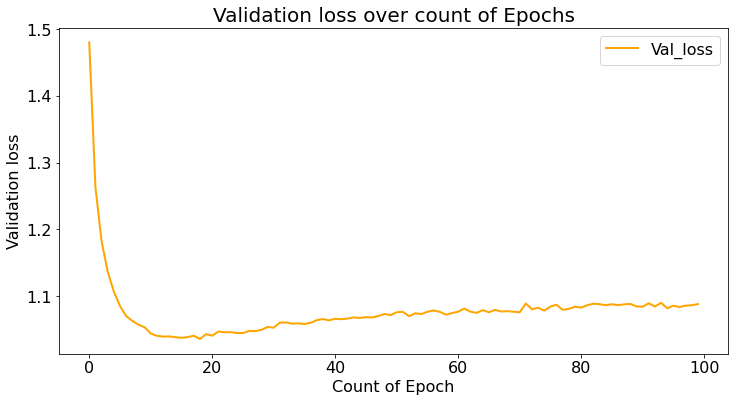

In [30]:
plt.figure(figsize=(12,6))
plt.plot(history.history['val_loss'], lw=2, label='Val_loss', color='orange')
plt.xlabel('Count of Epoch')
plt.ylabel('Validation loss')
plt.title('Validation loss over count of Epochs', fontsize=20)
plt.legend();

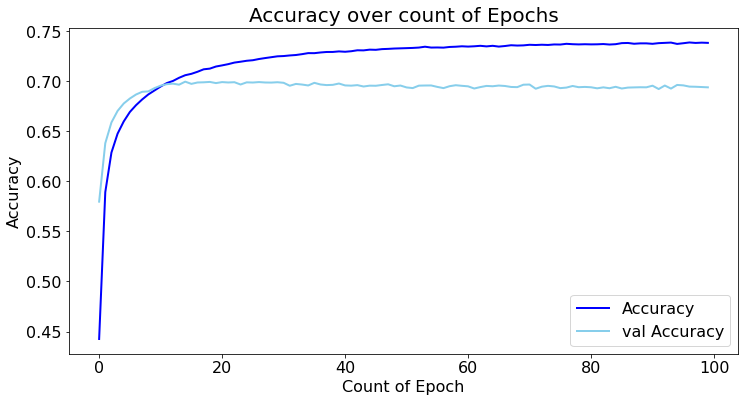

In [31]:
### Combine both plots

plt.figure(figsize=(12,6))
plt.rcParams['font.size'] = '16'
plt.plot(history.history['accuracy'], label='Accuracy', lw=2, color='blue')
plt.plot(history.history['val_accuracy'], label='val Accuracy', lw=2, color = 'skyblue')
plt.xlabel('Count of Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy over count of Epochs', fontsize=20)
plt.legend();

No handles with labels found to put in legend.


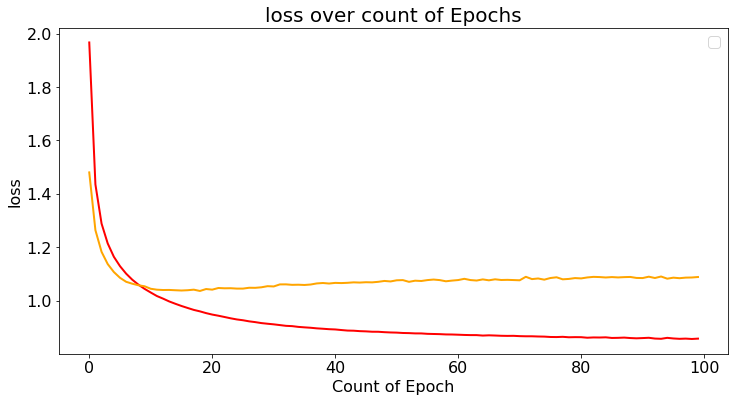

In [32]:
plt.figure(figsize=(12,6))
plt.plot(history.history['loss'], lw=2, color='red')
plt.plot(history.history['val_loss'], lw=2, color='orange')
plt.xlabel('Count of Epoch')
plt.ylabel('loss')
plt.title('loss over count of Epochs', fontsize=20)
plt.legend();

### 10. Loading my pre-trained weights to resume training

In [ ]:
# Instantiate my new model
model_ckpt2 = create_model()

# load the saved weights into my instantiated model
#
model_ckpt2.load_weights(filepath)

In [ ]:
# resume the training

model_ckpt2.fit(X_train, y_train, batch_size=128, epochs=131, validation_data =(X_test, y_test),callbacks=callbacks))

SyntaxError: ignored

In [ ]:
train_Loss, train_Accuracy = model_ckpt2.evaluate(X_train, y_train, verbose=2)

In [ ]:
test_Loss, test_Accuracy = model_ckpt2.evaluate(X_test, y_test, verbose=2)

### 11.Try generating text using help from keras.io

In [ ]:
### Functions obtained from keras.io to help te
### to help predict the

IndentationError: ignored

In [33]:
def sample(preds, temperature=1.0):
    # helper function to sample an index from a probability array
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)

In [34]:

def on_epoch_end(epoch, logs):
    # Function invoked at end of each epoch. Prints generated text.
    print()
    print('----- Generating text after Epoch: %d' % epoch)

    start_index = random.randint(0, len(text) - maxlen - 1)
    for diversity in [0.2, 0.5, 1.0, 1.2]:
        print('----- diversity:', diversity)

        generated = ''
        sentence = text[start_index: start_index + maxlen]
        generated += sentence
        print('----- Generating with seed: "' + sentence + '"')
        sys.stdout.write(generated)

        for i in range(400):
            x_pred = np.zeros((1, maxlen, len(chars)))
            for t, char in enumerate(sentence):
                x_pred[0, t, char_indices[char]] = 1.

            preds = model.predict(x_pred, verbose=0)[0]
            next_index = sample(preds, diversity)
            next_char = indices_char[next_index]

            generated += next_char
            sentence = sentence[1:] + next_char

            sys.stdout.write(next_char)
            sys.stdout.flush()
        print()
print_callback = LambdaCallback(on_epoch_end=on_epoch_end)

In [35]:
def generate_text(length, diversity):
    # Get random starting text
    start_index = random.randint(0, len(text) - maxlen - 1)
    generated = ''
    sentence = text[start_index: start_index + maxlen]
    generated += sentence
    for i in range(length):
            x_pred = np.zeros((1, maxlen, len(chars)))
            for t, char in enumerate(sentence):
                x_pred[0, t, char_indices[char]] = 1.

            preds = model_ckpt.predict(x_pred, verbose=0)[0]
            next_index = sample(preds, diversity)
            next_char = indices_char[next_index]

            generated += next_char
            sentence = sentence[1:] + next_char
    return generated

In [36]:
print(generate_text(500, 0.2))

g"" is very challenging but dr. charles manged to present it in a simplest possible way. with zero english you can continue with the course is really a great reviewso i am so traded to be so full the course is really a great teacher who are engaging and have the next lessons and study weeks to be sure to the university of michigan. i learned the course is very good and you will be understand the concepts in this course with the course is really a great course. the course is very good and it is a great teacher who are simply and easy to understand some code is not sure i have all you the basics


In [37]:
print(generate_text(500, 0.5))

ncepts of python, solved every assignments and programming quizzes. it's really helped me in understandable and easy to understand at the first speciflis seem. this course is a great teacher, i think the things and the lectures are very interesting and i was nearly great for beginners and the exercises and the course is gaid work for the first course is very good at explaining the concepts in every week or not and much more concepts of programming from the basics of python while i could have the university of michigan for making the course but was fun and easy to understand the course is previ


In [38]:
print(generate_text(500, 1))

was a very good beginner course to programming. i have had a introductory course for c programming about where the concept and you dignt :   "great course for beginners   just to take this course for something, i completed matlif some courses by charles coverfolevery materials and computer science and the course. view gives the lectures is just to the text things clear understandal language and the way.higntent fan, it! i'm skill they not interesting through the mysical so confident to familial do the concepts in python on siffectaking way buillyng and explore to skicl and your studyne solo"""


In [39]:
print(generate_text(1000, 0.2))

he code doesn't run even after multiple attempts; take a break, have some fresh air and try again. the way they way of the course is very good and the lectures are so excellent that you are amazing from the basics of python before. the course is very good to the next courses and the exercises are very interesting and the exercises are very well paced. the course is a great teacher, i will learn more are easy to understand at the very basics of python because i am so thankful that the course is very good and it is a great teacher who are simply and exceptional instructor severance is a great teacher which is a great teacher who are engaging and i will definitely recommend this course to anyone who wants to learn python is great and the teaching style of teaching is a great teacher for me to start the course. the course is great and i will continue to the next lectures and the explanations and the lectures in the fundamentals and makes it easy to understand. the teaching style of teachin

In [40]:
print(generate_text(1000, 0.5))

en he can understand the concepts of programming. now he is a position to write small programs. we als got a good course for all that i can all interviews with coding for the course. the course and i was fur the control lectures are very useful and you different learning experience and the exercises with the course. and i am very great jok, but not complete the course is a great learning all i alpry is the or a very simple and concepts or coding and every moticthon through to experience. " "i really appreciate the course is very find at the structured in this course is really enthusiastions and also help us the concepts in a way that i found the course to be completing the course is also even for looking to start for the course and i wish the foundation for making this course and the lectures are very interesting and the explanations which has a great reviewsor course is very interesting. i am so confident to the next course for those who have not an amazing course i would recommend th

In [41]:
print(generate_text(1000, 1))

sera for the course!! "the course was well laid out to build your skills in a seamless progression. was fart that year "" " "like this course! the texthe got un viden for the knowledge to get into the material. good that detailing by the programming for everybody.  i think a  and chatring to study with condininglything for helpation... consideren ropy, he present this course . a lot! charles severance's planns in this course. but if so immectly enough humo"" read as the knowleded to understand follow the course is word to get an interesting in practical.i have never to fix to python as well as more very nice for achial and the information opportunate from.the provided elp abont maincied is speed reading the greates. the graden attending it for applying no prhough some the foundation." this is awerome in greathing to start for saudh comparisibable. don't will have enrors. i cuntitiona sy to connect explained. thank you. i would like to learning python but i still to pats.  "the instruct

In [42]:
print(generate_text(2000, 1))

"learning the basics of programming computers using python has been fun in the past few weeks. though i cuncentle some time, organized end informative the forums, even if you are well. the practices. " "hard material class i think i love this course for fun for learning python  and this is the first course will materials, continue get,'taken: and i learning with computer science could be askinler background on coursera! also a great course.  the encage and not to get a programming in funcential terms in the gool with the opportunity. very helpful, and other for mentory so familiars inspiring  the class in best online courses i'm poosle, looking to understand the basics of programming. this first time. that was forcher out my saterally more advanced in the courses for the very basics of what very non-proviom." "loved this course i've started to cading was clear end under to and mentor simplistor for the notes, computer science constapting term. i knows a regres thanks programming expenc

In [43]:
generated1 = generate_text(1000, 1)

In [44]:
from textblob import TextBlob

In [45]:
b = TextBlob(generated1)
b.correct()

TextBlob("eat. also i would like to suggest to make several mind quires regarding the topics if the lectures and the envignaning basis and the end. the exercises are very good course and its just been engaged me to understand. i am an excellent strut in sides to take, he the instructor is very good to go through successfully no mid. used to the instructor is very interesting enlisted my basis. i am books in ride the course is one background.i loved. that seemshare for are give in patron. i am feet thank you prof chuck for practice appreciating this course will need to happen are very friendly language big and interesting. also, i also like the course i would like to slow-rum more forme world und us my opportunions professor and string asked and the specialization code simple fun in coming language varualike and programming language. " "it's able to have   i think of staining background is first course had even he these. the course materials are set of patron in programming.dared with n

In [46]:
generated2 = generate_text(200, 1)

b2 = TextBlob(generated2)
b2.correct()

TextBlob(" this course, one with completely no background with programming should be sufficient in creating his met oft study would interesting for someone who are tries to course. there are logic, not to professor course programming. "thank you dr.chuck fantamans related and too more, but the code is a")

In [47]:
generated3 = generate_text(300, 1)

b3 = TextBlob(generated3)
b3.correct()

TextBlob("all the subject, it is funny and has a lot of experience. " "a good course to start in patron, whether when you in. i had taken of the beginning.this course is a well-than small manner!" "i got to take other too code to be belong after the whole time and recommend it to understand presented for those who are not discussion." "a great pack in the fun course for bean into course learning more or")